In this notebook, we will try to train a Random Forest model using permissions from android applications.

<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train.
For convenience, here on out we will use the already exported data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
# Read the CSV file
df = pd.read_csv('permissions_labeled_dataset.csv')
df

,name,ANDROID.PERMISSION.READ_EXTERNAL_STORAGE,ANDROID.PERMISSION.READ_PHONE_STATE,Android.permission.CALL_PHONE,Android.permission.CHANGE_CONFIGURATION,Android.permission.SYSTEM_ALERT_WINDOW,FULLSCREEN.FULL,Intent.FLAG_GRANT_READ_URI_PERMISSION,Intent.FLAG_GRANT_WRITE_URI_PERMISSION,MediaStore.Images.Media.EXTERNAL_CONTENT_URI,...,zoiwdzml.vynuw.glhpqs,zqzulr.ltqc.zwilnr,zrvfolm.cjlt.ewrs,zugwl.kbkmzb.vzvzm,zvayo.qwkucvn.gejbbw,zwbp.eejtyc.geukpacr,zxjz.brwvdng.lhoiw,zytit.fqntnjmm.bazaeag,zzag.otkdp.lvntgqsd,detection
0,org.microg.nlp.backend.ichnaea_20036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
1,net.casimirlab.frigoligo_34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
2,by.yauhenl.gardine_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
3,org.mult.daap_51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
4,com.falconware.prestissimo_11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21462,bf0f284c1ec994606bebe7c2e713f5b2e789a8a9ae8799...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,trojan
21463,0f6a8d3f76e60fc1561a2f69761e328e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,trojan
21464,db2d8008dd39b02e5731c435e5fda10e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,adware
21465,da3fdd06b7c6b3099905e46de98af328,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [2]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_1608/2932402478.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)


detection
benign      1000
adware       200
exploit      200
hacktool     200
spyware      200
trojan       200
Name: count, dtype: int64

In [3]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h1>Training the RF Classifier</h1>

In [5]:
# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Generate predictions
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9225
              precision    recall  f1-score   support

      adware       0.76      0.91      0.83        34
      benign       0.95      1.00      0.97       199
     exploit       0.88      0.88      0.88        33
    hacktool       1.00      0.95      0.98        44
     spyware       0.93      0.83      0.88        48
      trojan       0.90      0.67      0.77        42

    accuracy                           0.92       400
   macro avg       0.90      0.87      0.88       400
weighted avg       0.92      0.92      0.92       400



In [6]:
unique_classes = ['adware', 'benign', 'exploit', 'hacktool', 'spyware', 'trojan']

print(unique_classes)

['adware', 'benign', 'exploit', 'hacktool', 'spyware', 'trojan']


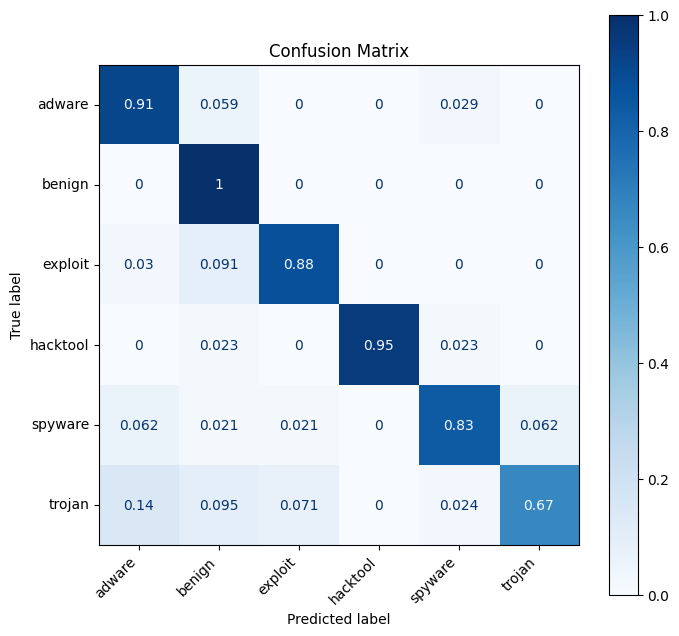

In [7]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

In [8]:
# Save the trained model
import joblib

# Assuming the trained model is stored in a variable called 'dt_model'
joblib.dump(rf_clf, 'random_forest_model.joblib')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Load the trained Decision Tree model
clf = joblib.load('random_forest_model.joblib')


<h1>Handling Class Imbalance with SMOTE</h1>

In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Re-train the Random Forest classifier with balanced data
rf_clf.fit(X_resampled, y_resampled)

# Generate predictions
y_pred = rf_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      adware       0.76      0.85      0.81        34
      benign       0.93      0.96      0.95       199
     exploit       0.73      0.73      0.73        33
    hacktool       1.00      0.95      0.98        44
     spyware       0.83      0.79      0.81        48
      trojan       0.83      0.69      0.75        42

    accuracy                           0.89       400
   macro avg       0.85      0.83      0.84       400
weighted avg       0.88      0.89      0.88       400



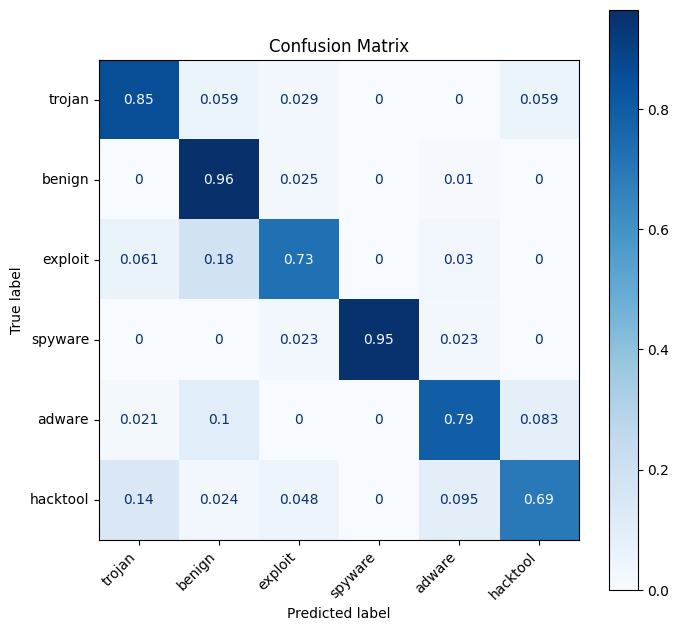

In [9]:
# Plot confusion matrix
unique_classes = y_test.unique()

# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()